# Implementing a Neural Network in NumPy

Rationale: libraries such as PyTorch hide many of the key algorithmic details behind implementing and training neural networks. To really understand neural networks and the backpropagation algorithm, it is very helpful to implement everything yourself

Goal: to train a neural network to classify a handwritten digit as either a 3 or a 9. We will be using a subset of the famous MNIST dataset. The neural network will be trained using mini-batch stochastic gradient descent (SGD).

In [1]:
from hw2 import get_mnist_threes_nines
from hw2 import display_image
import numpy as np
import pickle
import copy
import matplotlib.pyplot as plt

# 1.2

# part a

QUESTION: Backpropagation is quite tricky to implement correctly. You will verify that the gradients computed by your backpropagation code are correct by comparing its output to gradients computed by finite differences. Let $f: \mathbb{R}^d \to \mathbb{R}$ be an arbitrary function (for example, the loss of a neural network with $d$ weights and biases), and let $a$ be a $d$-dimensional vector. You can approximately evaluate the partial derivatives of $f$ as: \
$ \frac{\partial f}{\partial x_k} \approx \frac{f(\dots, a_k + \epsilon, \dots) - f(\dots, a_k - \epsilon, \dots)}{2\epsilon}$ \
where $\epsilon$ is a small constant. As $\epsilon$ approaches 0 , this approximation theoretically becomes
exact, but becomes prone to numerical precision issues. $\epsilon = 10^{−5}$ usually works well. Implement a finite differences checker, which you will use later to verify the correctness of your
backpropagation implementation.

In [2]:
def nn_finite_difference_checker(X, y, weights, biases, activations):
    grad_Ws, grad_bs = copy.deepcopy(weights), copy.deepcopy(biases) # just to have the same shape
    eps = 1e-5
    
    L = 0
    for layer in weights:
        N = 0
        grad_W = layer
        for neuron in layer:
            W = 0
            for weight in neuron:
                weight_plus_eps = copy.deepcopy(weights)
                weight_minus_eps = copy.deepcopy(weights)
                
                weight_plus_eps[L][N][W] += eps
                weight_minus_eps[L][N][W] -= eps
                
                output_plus_eps = forward_pass(X, weight_plus_eps, biases, activations)[0] # pass in X_batch
                loss_plus_eps = logistic_loss(output_plus_eps, y)[0]

                output_minus_eps = forward_pass(X, weight_minus_eps, biases, activations)[0]
                loss_minus_eps = logistic_loss(output_minus_eps, y)[0]
                
                grad_Ws[L][N][W] = ( loss_plus_eps.mean() - loss_minus_eps.mean()) / (2*eps)
                
                W += 1 
            N += 1
        L += 1
        
    L = 0
    for layer in biases:
        N = 0
        for neuron in layer.T:
            # one bias term per neuron
            bias_plus_eps, bias_minus_eps = copy.deepcopy(biases), copy.deepcopy(biases)
            bias_plus_eps[L].T[N] += eps
            bias_minus_eps[L].T[N] -= eps

            bias_output_plus_eps = forward_pass(X, weights, bias_plus_eps, activations)[0]
            loss_bias_plus = logistic_loss(bias_output_plus_eps, y)[0]
            
            bias_output_minus_eps = forward_pass(X, weights, bias_minus_eps, activations)[0]
            loss_bias_minus = logistic_loss(bias_output_minus_eps, y)[0]
            
            grad_bs[L].T[N] = (loss_bias_plus.mean() - loss_bias_minus.mean()) / (2*eps)
            
            N += 1
        L += 1
        
    return grad_Ws, grad_bs

# part b

QUESTION: Here, we will implement several helper functions that we will combine in the next two parts (rest of question truncated as it just gives details about how to implement these helper functions).

In [3]:
# param s: Numpy array of arbitrary shape
def sigmoid_activation(s):
    sigmoid = np.where(s < 0, np.exp(s, where=s<0)/(1+np.exp(s, where=s<0)), 1/(1+np.exp(-s, where=s>=0)))
    grad_sigmoid = np.where(s < 0, np.exp(s, where=s<0)/np.square(1+np.exp(s, where=s<0)),
                            np.exp(-s, where=s>=0)/np.square(1+np.exp(-s, where=s>=0)))
    
    # need to clip the output between eps and 1-eps for eps=1e-15
    eps = 1e-15
    np.clip(sigmoid, eps, 1-eps, out=sigmoid)
    np.clip(grad_sigmoid, eps, 1-eps, out=grad_sigmoid)
    
    return sigmoid, grad_sigmoid

In [4]:
# param g: is the output of the neural network
# param y: is the array of true labels
def logistic_loss(g, y):
    #assert g.shape == y.shape, "shape of g doesn't match shape of y"
    loss = - np.multiply(y, np.log(g)) - np.multiply((1-y), np.log(1-g))
    dL_dg = np.divide((1-y), (1-g)) - np.divide(y, g)
                    
    return loss, dL_dg

In [5]:
# param s: n by d array
def relu_activation(s):
    activated_s = np.maximum(s, np.zeros(np.shape(s)))
    partial_derivs = np.where(activated_s == 0, 0, 1)
    
    return activated_s, partial_derivs

In [6]:
# param x: n by d_(L-1) matrix consisting of mini-batch neurons for layer L-1 (n data points, d_(L-1) neurons)
# param W: d_(L-1) by d_(L) weight matrix for layer L
# param b: 1 by d_(L) bias vector for layer L
# param activation_fn: applies elementwise activation to S_(L)
def layer_forward(x, W, b, activation_fn):
    
    S = np.dot(x, W) + b
    S_activated, S_activated_grad = activation_fn(S)
    out_x = S_activated
    
    cache = (x, W, S_activated_grad) # X_(L-1), w_L, dg/dS
    return out_x, cache

# part c

QUESTION: Fully implement a forward pass of the neural network. (rest of question truncated).

In [7]:
# param layer_dims: a list of the dimensions of each layer, starting with the input layer
# e.g. layer_dims = [784, 200, 1]
def create_weight_matrices(layer_dims):
    weight_matrix = []

    for i in range(len(layer_dims)-1):
        weight_matrix.append([])
        for j in range(layer_dims[i]):
            weight_matrix[i].append( np.random.normal(loc=0, scale=0.01, size=layer_dims[i+1]).tolist() )
            
    # now have a list of lists, and we want an array of lists
    for i in range(len(weight_matrix)):
        weight_matrix[i] = np.asarray([weight_matrix[i]])[0]
    
    return weight_matrix

In [8]:
def create_bias_vectors(layer_dims):
    bias_vector = []
    
    index = 0
    for layer_dim in layer_dims[1:]: # don't want bias vectors for the input layer
        bias_vector.append([])
        for number_of_neurons in range(layer_dim):
            bias_vector[index].append(np.random.normal(loc=0, scale=0.01))
        index += 1
        
    for i in range(len(bias_vector)):
        bias_vector[i] = np.asarray([bias_vector[i]])
            
    return bias_vector

In [9]:
# param X_batch: n by 784 mini-batch of flattened images
def forward_pass(X_batch, weight_matrices, biases, activations):
    
    x = X_batch
    caches = []
    for i in range(len(weight_matrices)):
        x, cache = layer_forward(x, weight_matrices[i], biases[i], activations[i])
        caches.append(cache)
    
    return x, caches

In [16]:
weight_matrices

[array([[-0.00427742, -0.00175934],
        [ 0.02597773,  0.01450439],
        [ 0.01462573,  0.02592555],
        [ 0.00215992,  0.00019207]]),
 array([[ 0.004514  ],
        [-0.00021486]])]

In [12]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

forward_pass(X_batch, weight_matrices, biases, [relu_activation, sigmoid_activation])

(array([[0.49732013],
        [0.49732464]]),
 [(array([[ 0.98178495,  0.32574182,  0.39367602,  0.17309336],
          [-0.36270975,  0.05783132,  1.09087634, -0.19926157]]),
   array([[-0.00427742, -0.00175934],
          [ 0.02597773,  0.01450439],
          [ 0.01462573,  0.02592555],
          [ 0.00215992,  0.00019207]]),
   array([[0, 1],
          [1, 1]])),
  (array([[0.        , 0.00770579],
          [0.00477529, 0.02418912]]),
   array([[ 0.004514  ],
          [-0.00021486]]),
   array([[0.24999282],
          [0.24999284]]))])

# part d

QUESTION: We are now at the most difficult part of this problem: implementing the backward pass. Write a function called backward pass that uses the derivative computed in logistic loss and the layer caches to compute the gradients of each of the weight matrices and bias vectors. Implementing this correctly will require both a strong understanding of the backpropagation algorithm, as discussed in lecture, and careful coding/debugging to make sure each step is implemented appropriately. Your finite differences implementation will come in handy here to make sure that your backpropagation implementation is working correctly.

In [39]:
def backward_pass(dL_dg, layer_caches):
    
    dL_dW, dL_db = [], []
    
    dL_dg = np.array(dL_dg).reshape(len(dL_dg), 1) # shape for dL_dg is (2,). Want to make it (2, 1)
    num_data_points = len(layer_caches[0][0])
    
    # output layer
    L = len(layer_caches) - 1
    
    x_h, W_h_o, dg_dS_o = layer_caches[L] # x_hidden, W_hidden_output, dg_dS_output
    deltas_output = (dL_dg * dg_dS_o) # deltas_output is 2x1 b/c of 2 data points
    grad_W_output = np.dot(x_h.T, deltas_output) / num_data_points
    dL_dW.insert(0, grad_W_output)
    
    dL_db.insert(0, deltas_output.mean())
    
    # hidden layers
    running_deltas = deltas_output # for each layer, will need the above layer's deltas
    running_weights = W_h_o # for each layer, will need next set of weights
    
    for layer_cache in reversed(layer_caches[:-1]): # exclude last element of layer_caches
        x_layer_minus_1, W_layer_minus_1_to_layer, dg_dS_layer = layer_cache
        
        deltas_hidden = np.multiply(np.dot(running_deltas, running_weights.T), dg_dS_layer)
        grad_W_hidden = np.dot(x_layer_minus_1.T, deltas_hidden) / num_data_points
        dL_dW.insert(0, grad_W_hidden)
        
        print(running_deltas)
        print(running_weights.T)
        print(dg_dS_layer)
        print()
        print(x_layer_minus_1.T)
        print(deltas_hidden)
        print(np.dot(x_layer_minus_1.T, deltas_hidden))
        #print(running_weights)
        #print(dg_dS_layer)
        #print(deltas_hidden)
        
        running_deltas = deltas_hidden
        running_weights = W_layer_minus_1_to_layer # e.g. if layers are i,h,o and current layer is h
                                                   # then running_weights now = W_i_h
            
        dL_db.insert(0, deltas_hidden.mean(axis=0))
    
    return dL_dW, dL_db

In [40]:
activations = [relu_activation, sigmoid_activation]
output, layer_caches = forward_pass(X_batch, weight_matrices, biases, activations)
output = np.reshape(output, (y_batch.shape[0]))
loss, dL_dg = logistic_loss(output, y_batch)

grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)

[[-0.50267987]
 [-0.50267536]]
[[ 0.004514   -0.00021486]]
[[0 1]
 [1 1]]

[[ 0.98178495 -0.36270975]
 [ 0.32574182  0.05783132]
 [ 0.39367602  1.09087634]
 [ 0.17309336 -0.19926157]]
[[-0.          0.00010801]
 [-0.00226907  0.00010801]]
[[ 8.23015441e-04  6.68643062e-05]
 [-1.31223570e-04  4.14282187e-05]
 [-2.47527970e-03  1.60339793e-04]
 [ 4.52139356e-04 -2.82613642e-06]]


# part e

QUESTION: Now it is time to bring it all together. Using a mini-batch size n of 100 and a step size of 0.1 for SGD, implement a training loop that iterates over the mini-batches of data, computes the forward pass, computes the loss, computes the backward pass, and updates the weights using SGD. Note that typically, instead of randomly sampling each mini-batch, the training data is shuffled and then divided up into mini-batches for efficiency. Each loop over the entire dataset is commonly referred to as an epoch, and the training data is reshuffled for each epoch. Train a two layer network with a hidden dimension of 200 (i.e. layer dims = [784, 200, 1])
for 5 epochs. For each timestep, record the average loss across the training mini-batch, the
average accuracy across the training mini-batch, the average loss across the entire test set, and
the average accuracy across the entire test set. You should be able to achieve a test accuracy of
around 98%.

In [34]:
pip install mnist

Note: you may need to restart the kernel to use updated packages.


In [148]:
(X_train, y_train), (X_test, y_test) = get_mnist_threes_nines()
num_train_data = X_train.shape[0]
X_train_image_size = X_train.shape[1] * X_train.shape[2]
X_train_flat = np.reshape(X_train, (num_train_data, X_train_image_size))

num_test_data = X_test.shape[0]
X_test_image_size = X_test.shape[1] * X_test.shape[2]
X_test_flat = np.reshape(X_test, (num_test_data, X_test_image_size))

In [150]:
mini_batches_X = [X_train_flat[i:i+100] for i in range(0, num_train_data, 100)] # 12080/100 = 120.8
mini_batches_y = [y_train[i:i+100] for i in range(0, num_train_data, 100)]

weight_matrices_train = create_weight_matrices([784, 200, 1])
bias_vectors_train = create_bias_vectors([784, 200, 1])
activations = [relu_activation, sigmoid_activation]

In [151]:
step_size = 0.1

avg_loss_training, avg_accuracy_training = [], []
avg_loss_test, avg_accuracy_test = [], []
total_runs = 0

G_of_w = weight_matrices_train
G_of_b = bias_vectors_train
num_weight_matrices = len(G_of_w)
num_bias_matrices = len(G_of_b)

test_misclassifications = []

for epoch in range(5):
    
    for mini_batch_X, mini_batch_y in zip(mini_batches_X, mini_batches_y):
        
        # training
        output_tr, layer_caches_tr = forward_pass(mini_batch_X, G_of_w, G_of_b, activations)
        output_tr = np.reshape(output_tr, (mini_batch_y.shape[0]))
        loss_tr, dL_dg_tr = logistic_loss(output_tr, mini_batch_y)
        dL_dW_tr, dL_db_tr = backward_pass(dL_dg_tr, layer_caches_tr)
        
        avg_loss_training.append(loss_tr.mean())
        avg_accuracy_training.append(len([1 for i,j in zip(output_tr, mini_batch_y) if np.round(i)==j]) 
                                     / len(output_tr) ) # assuming threshold = 0.5 so I'll use np.round
        
        # test
        output_test, layer_caches_test = forward_pass(X_test_flat, G_of_w, G_of_b, activations)
        output_test = np.reshape(output_test, (y_test.shape[0]))
        loss_test, dL_dg_test = logistic_loss(output_test, y_test)
        dL_dW_test, dL_db_test = backward_pass(dL_dg_test, layer_caches_test)
        
        avg_loss_test.append(loss_test.mean())
        avg_accuracy_test.append(len([1 for i,j in zip(output_test, y_test) if np.round(i)==j]) 
                                     / len(output_test) )
        
        test_misclassify = [i[0] for i,j in zip(enumerate(output_test), y_test) if np.round(i[1]) != j]
        test_misclassifications.append(test_misclassify)
        
        # SGD update
        for i in range(num_weight_matrices):
            G_of_w[i] = np.subtract(G_of_w[i], np.multiply(step_size, dL_dW_tr[i]))
        for i in range(num_bias_matrices):
            G_of_b[i] = np.subtract(G_of_b[i], np.multiply(step_size, dL_db_tr[i]))
            
        total_runs += 1 
    
    print('finished epoch #', epoch+1)

finished epoch # 1
finished epoch # 2
finished epoch # 3
finished epoch # 4
finished epoch # 5


# 1.3 deliverables

## 1.3 a

QUESTION: Compute the finite difference approximation to the gradients of the loss with respect to the
weights and biases of the neural network.

In [44]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)
grad_Ws, grad_bs = nn_finite_difference_checker(X_batch, 
                                                   y_batch, 
                                                   weight_matrices, 
                                                   biases, 
                                                   activations)
with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[ 4.12e-04  3.34e-05]
 [-6.56e-05  2.07e-05]
 [-1.24e-03  8.02e-05]
 [ 2.26e-04 -1.41e-06]]

[[-0.  ]
 [-0.01]]

[[-0.  0.]]

[[-0.5]]


## 1.3 b

### 1.3 b i)

QUESTION: What does sigmoid activation return for s = np.asarray([1., 0., -1.])?

In [19]:
s = np.asarray([1., 0., -1.])
sigmoid_activation(s)

(array([0.73105858, 0.5       , 0.26894142]),
 array([0.19661193, 0.25      , 0.19661193]))

### 1.3 b ii)

QUESTION: What does sigmoid activation return for s = np.asarray([-1000, 1000])? Ensure that your implementation of sigmoid activation is
numerically stable and does not cause overflows.

In [46]:
s = np.asarray([-1000, 1000])
sigmoid_activation(s)

(array([1.e-15, 1.e+00]), array([1.e-15, 1.e-15]))

### 1.3 b iii)

QUESTION: What is the derivative of the negative log-likelihood loss with respect to g?

$\frac{\partial L}{\partial g} = \frac{1-y}{1-g} - \frac{y}{g}$.

In [50]:
logistic_loss(output, y_batch)[1].mean() # dL_dg for the data from 'test_batch_weights_biases.pkl'

-2.0107681311389523

### 1.3 b iv)

QUESTION: Explain what is returned in cache in your layer forward implementation.

In layer_forward, we start at a layer L and want to go to layer L+1. We pass in the X's for layer L, the weights between layers L and L+1, the biases for layer L and the activation functions.

Cache stores the X's, the weights and the derivative of the activation function with respect to the weighted sum.
This is important because when we get to the backward pass, we'll need those three things in order to compute the delta's that were specified in lecture.

## 1.3 c

QUESTION: Report the average loss for the test data, weight, and biases provided.

In [51]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)
activations = [relu_activation, sigmoid_activation]
output, _ = forward_pass(X_batch, weight_matrices, biases, activations)
loss, dL_dg = logistic_loss(output, y_batch)
print(loss.mean())

0.6985168038536878


## 1.3 d

QUESTION: Report the gradients of the weights and biases computed from the test data using backpropagation. Compare these gradients to the finite differences approximation and make
sure the two gradients are close.

In [53]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
output, layer_caches = forward_pass(X_batch, weight_matrices, biases, activations)
output = np.reshape(output, (y_batch.shape[0]))
loss, dL_dg = logistic_loss(output, y_batch)

grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[ 4.12e-04  3.34e-05]
 [-6.56e-05  2.07e-05]
 [-1.24e-03  8.02e-05]
 [ 2.26e-04 -1.41e-06]]

[[-0.  ]
 [-0.01]]

[-0.  0.]

-0.502677616312691


## 1.3 e

### 1.3 e i)

QUESTION: Make a plot of the training and test losses per timestep

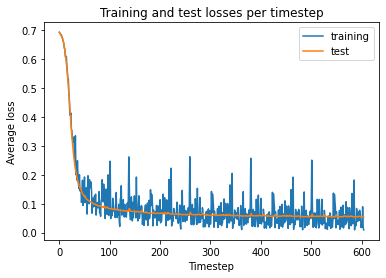

In [60]:
x = [i for i in range(total_runs)]
plt.plot(x, avg_loss_training, label = 'training')
plt.plot(x, avg_loss_test, label = 'test')
plt.xlabel('Timestep')
plt.ylabel('Average loss')
plt.title('Training and test losses per timestep')
plt.legend()

### 1.3 e ii)

QUESTION: Make another plot of the training and test accuracies per timestep.

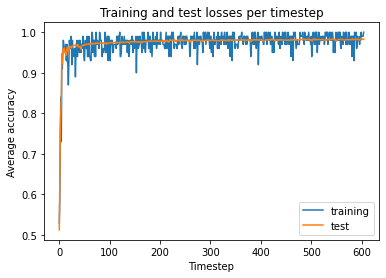

In [61]:
x = [i for i in range(total_runs)]
plt.plot(x, avg_accuracy_training, label = 'training')
plt.plot(x, avg_accuracy_test, label = 'test')
plt.xlabel('Timestep')
plt.ylabel('Average accuracy')
plt.title('Training and test losses per timestep')
plt.legend()

### 1.3 e iii)

QUESTION: Examine the images that your network guesses incorrectly, and explain at a high level
what patterns you see in those images.

In [135]:
test_misclassifications[600][:20]

[129,
 210,
 225,
 247,
 308,
 310,
 338,
 424,
 434,
 455,
 477,
 557,
 612,
 688,
 700,
 716,
 811,
 910,
 968,
 976]

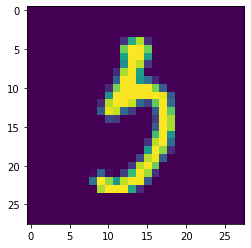

In [157]:
plt.imshow(X_test[968])

For misclassified images, here are some pattersn I noticed:
1) A lot of the handwritten numbers in the images are not drawn completely--for example, many of the 3's are cut off at the bottom or top. 
2) Additionally, some of the numbers are not cleanly drawn--they have superfluous strokes jutting out to the side.
3) Some of the numbers are tilted to the side--for example, some 9's were drawn almost rotated 90 degrees to one side.
4) Some numbers were so poorly drawn that I couldn't confidently classify them myself.

### 1.3 e iv)

QUESTION: Rerun the neural network training but now increase the step size to 10.0. What happens? You do not need to include plots here.

Upon increasing the step_size to 10, the training loss was much more variables. For the small step_size, the variation was small and the loss went down steadily. For the large step_size, the loss would go down but then spike up again from time to time in the initial time steps. This indicates that the gradient descent udpate may have been overshooting because of the large step size. The average accuracy also varied quite a lot more. 